In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

image_path = '/kaggle/input/kermany2018/oct2017/OCT2017 '
oct_csv_path = '/kaggle/input/oct-csv/'
train_dir = image_path + "/train/"
valid_dir = image_path + "/val/"
test_dir = image_path + "/test/"

In [14]:
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
cols = [x.upper() for x in classes]
dirs = [train_dir, valid_dir, test_dir]
label = {0: 'CNV', 1: 'DME', 2: 'DRUSEN', 3: 'NORMAL'}
IMG_SIZE = 224

# if we should read the directory structre, if False then use the CSV files already saved
# Once you generate the csv files you should probably download them and re-upload into kaggle and set this to FALSE
REGEN = False 

In [15]:
def create_df (path, classes=classes):
  df = pd.DataFrame(columns=['FILENAME', 'CNV', 'DME', 'DRUSEN', 'NORMAL'])
  for sub_dir in classes:
    condition = {'NORMAL': 0, 'CNV': 0, 'DME':0, 'DRUSEN': 0}
    files = os.listdir(path + sub_dir)
    if (sub_dir== 'NORMAL'):
      condition['NORMAL'] = 1
    elif (sub_dir == 'CNV'):
      condition['CNV'] = 1
    elif (sub_dir == 'DME'):
      condition['DME'] = 1
    else:
      condition['DRUSEN']= 1
    for f in files:
      df = df.append({'FILENAME': path +  sub_dir  + "/" + f, 
                      'NORMAL': condition['NORMAL'], 
                      'CNV': condition['CNV'],
                      'DME': condition['DME'],
                      'DRUSEN': condition['DRUSEN']}, ignore_index=True)
  return df

In [16]:
# Generting the DataFrames of the filenames
# this is primarily used so we can sub-sample files easier for the different training strategies
if (REGEN):
  train_df = create_df(train_dir)
  valid_df = create_df(valid_dir)
  test_df = create_df(test_dir)
  train_df.to_csv("train_data.csv")
  valid_df.to_csv("valid_data.csv")
  test_df.to_csv("test_data.csv")
else:
  train_df = pd.read_csv(oct_csv_path + "train_data.csv")
  valid_df = pd.read_csv(oct_csv_path + "valid_data.csv")
  test_df = pd.read_csv(oct_csv_path + "test_data.csv")

In [17]:
print ("Training Data: ", train_df.shape)
print ("Validation Data: ", valid_df.shape)
print ("Test Data: ", test_df.shape)

Training Data:  (83484, 5)
Validation Data:  (36, 5)
Test Data:  (972, 5)


In [18]:
# Printing out the # of samples for each subsample percentage 
print ("Trainig Data percentages:")
print (" 1% ==> ", int(.01 * train_df.shape[0]))
print (" 5% ==> ", int(.05 * train_df.shape[0]))
print ("10% ==> ", int(.1  * train_df.shape[0]))
print ("25% ==> ", int(.25 * train_df.shape[0]))
print ("50% ==> ", int(.5  * train_df.shape[0]))
print ("75% ==> ", int(.75 * train_df.shape[0]))
print ("90% ==> ", int(.9  * train_df.shape[0]))
print ("98% ==> ", int(.98 * train_df.shape[0]))

Trainig Data percentages:
 1% ==>  834
 5% ==>  4174
10% ==>  8348
25% ==>  20871
50% ==>  41742
75% ==>  62613
90% ==>  75135
98% ==>  81814


In [19]:
# Sampling 50% of the data
sample = train_df.sample(frac=0.1, random_state=10, axis=0)
sample.shape

(8348, 5)

In [20]:
# determine class weights to feed into neural network during training
def get_classweight(df):
  total = df.shape[0]
  num_norm = df['NORMAL'].sum()
  num_cnv = df['CNV'].sum()
  num_dme = df['DME'].sum()
  num_drusen = df['DRUSEN'].sum()
  norm_weight = (1/num_norm) * (total/4)
  cnv_weight = (1/num_cnv) * (total/4)
  dme_weight = (1/num_dme) * (total/4)
  drusen_weight = (1/num_drusen) * (total/4)
  class_weight = {0 : cnv_weight, 1: dme_weight,
                  2 : drusen_weight, 3: norm_weight}
  return class_weight

In [21]:
class_weight = get_classweight(sample)
class_weight

{0: 0.5654294229206177,
 1: 1.8387665198237886,
 2: 2.371590909090909,
 3: 0.7899318697956094}

In [22]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow.keras.applications as app
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
train_image_datagen = ImageDataGenerator(rotation_range=90, width_shift_range=[-.1,.1], height_shift_range=[-.1,.1],
                                         shear_range=0.25, zoom_range=0.3, horizontal_flip=True,
                                         vertical_flip=True, rescale = 1./255., validation_split=0.1)

# Setting the imgages to come from the dataframe where we specify the filenames and columns to use for "labels"
train_imgs = train_image_datagen.flow_from_dataframe(sample, directory=None, x_col='FILENAME', y_col=cols, subset="training",
                                        class_mode="raw", target_size=(IMG_SIZE,IMG_SIZE), batch_size=32, seed=10)
valid_imgs = train_image_datagen.flow_from_dataframe(sample, directory=None, x_col='FILENAME', y_col=cols, subset="validation",
                                        class_mode="raw", target_size=(IMG_SIZE,IMG_SIZE), batch_size=32, seed=10)

Found 7514 validated image filenames.
Found 834 validated image filenames.


In [24]:
# Creating the model based on Xception Network
input_layer = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = app.xception.Xception(include_top=False, weights="imagenet", input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model.trainable = True

x = base_model(input_layer)
x = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs=input_layer, outputs=output)
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 20,815,148
Non-trainable params: 54,528
_________________________________________________________________


In [25]:
# This code did not work, it caused I/O Error 5:
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics='accuracy')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(4,"micro"), "accuracy"])

In [26]:
# Creating a checkpoint to save the best model so that we can reload it once training is complete
checkpoint_cb = keras.callbacks.ModelCheckpoint("oct_xception50per.h5", save_best_only=True)
# Adding an an early stop callback to avoid overfitting in case the model is not improving after 5 consescutive epochs
earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [27]:
history = model.fit(train_imgs,  steps_per_epoch=230, epochs=100, verbose=1, validation_data=valid_imgs, 
                    class_weight=class_weight, callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/100
230/230 [==============================] - 223s 926ms/step - loss: 1.0664 - f1_score: 0.5924 - accuracy: 0.5924 - val_loss: 0.5027 - val_f1_score: 0.8285 - val_accuracy: 0.8285
Epoch 2/100
230/230 [==============================] - 150s 650ms/step - loss: 0.5324 - f1_score: 0.8170 - accuracy: 0.8170 - val_loss: 0.6992 - val_f1_score: 0.8094 - val_accuracy: 0.8094
Epoch 3/100
230/230 [==============================] - 148s 645ms/step - loss: 0.4587 - f1_score: 0.8466 - accuracy: 0.8466 - val_loss: 0.5149 - val_f1_score: 0.7998 - val_accuracy: 0.7998
Epoch 4/100
230/230 [==============================] - 148s 643ms/step - loss: 0.4079 - f1_score: 0.8611 - accuracy: 0.8611 - val_loss: 0.4880 - val_f1_score: 0.8165 - val_accuracy: 0.8165
Epoch 5/100
230/230 [==============================] - 147s 639ms/step - loss: 0.3560 - f1_score: 0.8836 - accuracy: 0.8836 - val_loss: 0.4653 - val_f1_score: 0.8177 - val_accuracy: 0.8177
Epoch 6/100
230/230 [==============================] - 

In [28]:
test_image_datagen = ImageDataGenerator( rescale = 1./255.)

test_imgs = test_image_datagen.flow_from_dataframe(test_df, directory=None, x_col='FILENAME', y_col=cols, validate_filenames=True,
                                        class_mode="raw", target_size=(224,224), batch_size=32, shuffle=False)

Found 968 validated image filenames.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 4 invalid image filename(s) in x_col="FILENAME". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [29]:
model.load_weights("oct_xception50per.h5")
model.evaluate(test_imgs)

31/31 [==============================] - 12s 380ms/step - loss: 0.2108 - f1_score: 0.9215 - accuracy: 0.9215


[0.21077020466327667, 0.9214876294136047, 0.9214876294136047]

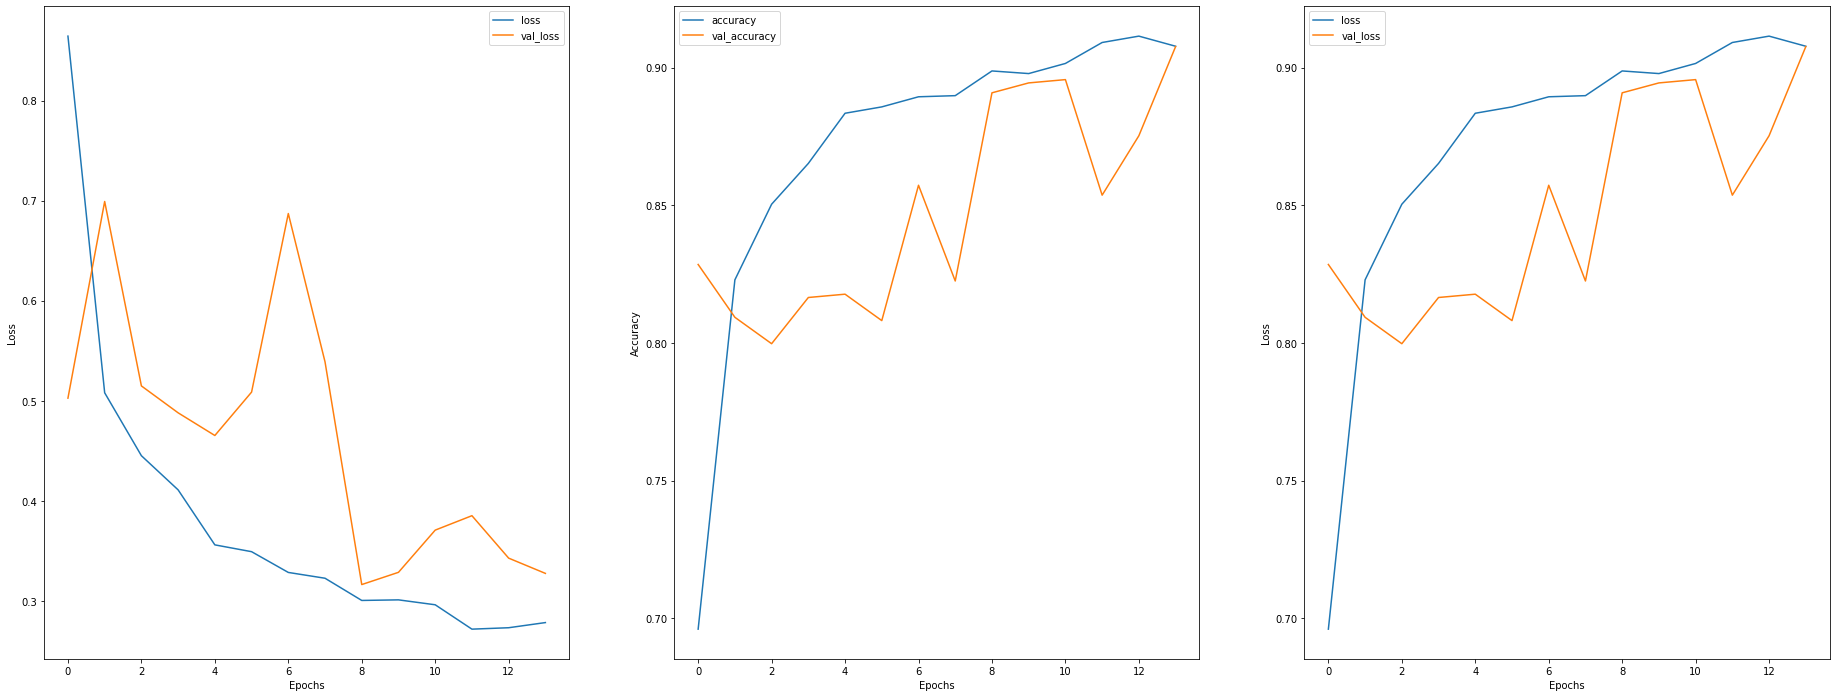

In [30]:
#Plotiting training results
plt.figure(figsize=(32,12))
plt.subplot(1,3,1)
plt.plot(range(len(history.history["loss"])), history.history['loss'], label="loss")
plt.plot(range(len(history.history["loss"])), history.history['val_loss'], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,3,2)
plt.plot(range(len(history.history["loss"])), history.history["accuracy"], label="accuracy")
plt.plot(range(len(history.history["loss"])), history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,3,3)
plt.plot(range(len(history.history["loss"])), history.history['f1_score'], label="loss")
plt.plot(range(len(history.history["loss"])), history.history['val_f1_score'], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()